<a href="https://colab.research.google.com/github/ldorje1/SAR_robustness/blob/main/attack_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


dafsfdasfasd

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/myMMwave/attack_v3/sar_imaging_pytorch_main') # add path to the notebook folder

Mounted at /content/drive


## 1. MORE REALISTIC ATTACK (with constraints on x_attack)


In [ ]:
#import sys
import scipy.io as sio
import torch

#sys.path.append('/content/drive/MyDrive/Colab Notebooks/myMMwave/attack_v3/sar_imaging_pytorch_main')
from sar_imaging_pytorch.imaging.rma import RMA

# -------- Parameters --------
n_fft_space = 1024  # FFT points for Spatial-FFT
dx, dy = 1, 1       # Sampling distances in mm for x and y axes
z_target = 185      # Target distance in mm
im_size = [-150, 150, -150, 150]  # Imaging area size in mm

# Initialize the RMA object
rma = RMA(nFFTspace=n_fft_space, z0=z_target*1e-3, dx=dx, dy=dy, bbox=im_size)

# -------- Load Data --------
# Load clean SAR data
data_path_clean = '/content/drive/MyDrive/Colab Notebooks/myMMwave/attack_v3/sarData_rangeFocused_knife.mat'
data = sio.loadmat(data_path_clean)
x_0 = torch.tensor(data['sarData'], dtype=torch.complex64)  # Clean SAR data

I_clean = rma(x_0) # clean image without the attack
#rma.plot_result(torch.abs(I_clean))

# Load target image pixels
target_image_path = '/content/drive/MyDrive/Colab Notebooks/myMMwave/attack_v3/sar_image_target_pixel.pt'
I_target = torch.load(target_image_path)
#rma.plot_result(I_target)

# -------- Initialize Attack Signal --------
# Create `x_attack` with random complex values, requires gradient for optimization
x_attack = torch.randn_like(x_0, dtype=torch.complex64, requires_grad=True)
#rma.plot_result(torch.abs(rma(x_attack)))

x_adv = x_0 + x_attack

#rma.plot_result(torch.abs(rma(x_adv)))

<ipython-input-2-e24202873cf1>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  I_target = torch.load(target_image_path)


In [ ]:
import matplotlib.pyplot as plt

# Loss function: Magnitude MSE
def magnitude_mse_loss(output, target):
    return torch.mean((torch.abs(output) - target) ** 2)

# Reference MSE for normalization
reference_mse = magnitude_mse_loss(torch.abs(I_clean), I_target)
print(f"Reference MSE between I_clean and I_target: {reference_mse.item()}")

# -------- Adversarial Attack Optimization with Epsilon Constraint --------
def optimize_adversarial_attack(x_0, I_target, rma, num_iterations=100, learning_rate=1e-4, epsilon=0.1):

    # Reinitialize x_attack each time the function is called
    x_attack = torch.randn_like(x_0, dtype=torch.complex64, requires_grad=True)

    # List to store loss values for plotting
    losses = []

    # Iterative Optimization
    for i in range(num_iterations):

        # Zero the gradients
        x_attack.grad = None

        # Generate adversarial SAR data and compute adversarial image
        x_adv = x_0 + x_attack
        I_adv = rma(x_adv)

        # Calculate the MSE loss
        loss = magnitude_mse_loss(I_adv, I_target)
        normalized_loss = loss / reference_mse
        losses.append(normalized_loss.item())

        # Backward pass: compute gradients
        loss.backward()

        # Update x_attack using gradient descent
        with torch.no_grad():
            x_attack -= learning_rate * x_attack.grad

            # Enforce the epsilon constraint on x_attack
            norm = torch.norm(x_attack)
            if norm > epsilon:
                x_attack *= (epsilon / norm)

        # Print progress every few iterations
        if i % 5 == 0:
            print(f'Iteration {i}, Normalized Loss: {normalized_loss.item()}')

    # Final adversarial data and success metric
    optimized_x_attack = x_attack.detach()

    norm = torch.norm(optimized_x_attack)
    print(f"Norm of x_attack after optimization: {norm}")

    optimized_x_adv = x_adv.detach()  # Detach to visualize
    final_mse = magnitude_mse_loss(rma(optimized_x_adv), I_target).item()
    print(f"Final MSE between I_adv and I_target: {final_mse}")

    # Result Visualization
    rma.plot_result(torch.abs(rma(optimized_x_adv)))

    # Plot loss vs iteration
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_iterations), losses, marker='o')
    plt.title('Loss vs. Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (Magnitude MSE)')
    plt.grid(True)
    plt.show()


Reference MSE between I_clean and I_target: 21960996159488.0


Reference MSE between I_clean and I_target: 21960996159488.0
Iteration 0, Normalized Loss: 1.0000001192092896
Iteration 5, Normalized Loss: 0.13486140966415405
Iteration 10, Normalized Loss: 0.035741694271564484
Iteration 15, Normalized Loss: 0.02243437059223652
Iteration 20, Normalized Loss: 0.019625019282102585
Iteration 25, Normalized Loss: 0.0185425765812397
Iteration 30, Normalized Loss: 0.01793614961206913
Iteration 35, Normalized Loss: 0.01753265969455242
Iteration 40, Normalized Loss: 0.017237171530723572
Iteration 45, Normalized Loss: 0.017006345093250275
Iteration 50, Normalized Loss: 0.016817616298794746
Iteration 55, Normalized Loss: 0.016658173874020576
Iteration 60, Normalized Loss: 0.01652025431394577
Iteration 65, Normalized Loss: 0.016398834064602852
Iteration 70, Normalized Loss: 0.016290485858917236
Iteration 75, Normalized Loss: 0.016192741692066193
Iteration 80, Normalized Loss: 0.01610376499593258
Iteration 85, Normalized Loss: 0.016022155061364174
Iteration 90, N

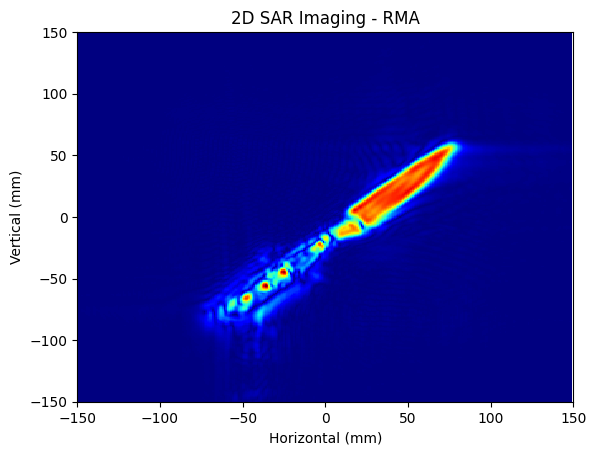

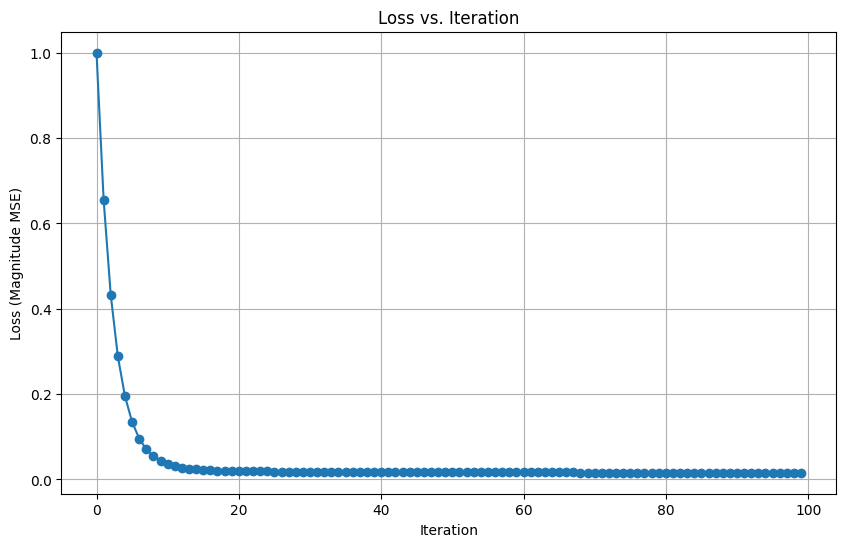

In [ ]:
# Calculate MSE between I_clean and I_target for reference
reference_mse = magnitude_mse_loss(torch.abs(I_clean), I_target)
print(f"Reference MSE between I_clean and I_target: {reference_mse.item()}")


# Now you can call the function whenever you want to restart the optimization
num_iterations=100
learning_rate=1e-2
epsilon=1900000.0
optimize_adversarial_attack(x_0, I_target, rma,num_iterations=num_iterations, learning_rate=learning_rate, epsilon=epsilon)

## 2. MORE REALISTIC ATTACK (without constraints on x_attack)


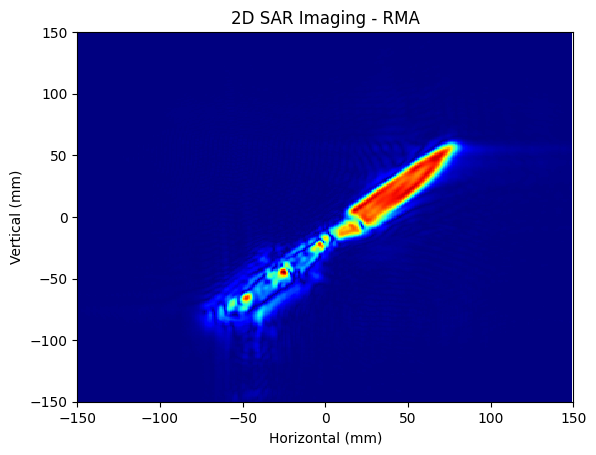

<ipython-input-11-8519959b5697>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  I_target = torch.load(target_image_path)


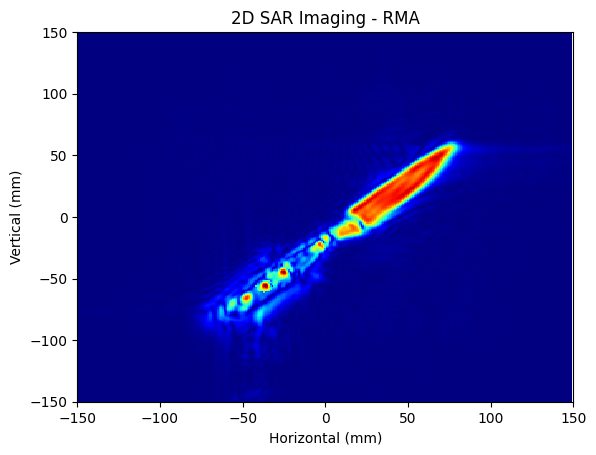

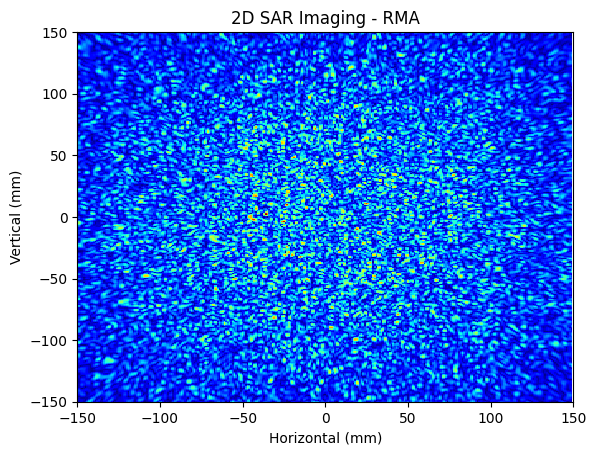

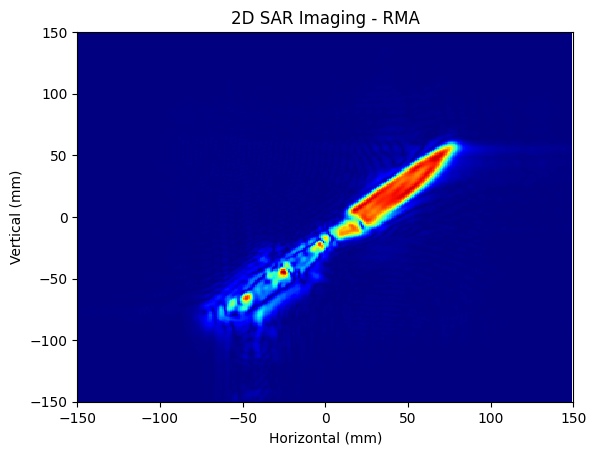

In [ ]:
#import sys
import scipy.io as sio
import torch

#sys.path.append('/content/drive/MyDrive/Colab Notebooks/myMMwave/attack_v3/sar_imaging_pytorch_main')
from sar_imaging_pytorch.imaging.rma import RMA

# -------- Parameters --------
n_fft_space = 1024  # FFT points for Spatial-FFT
dx, dy = 1, 1       # Sampling distances in mm for x and y axes
z_target = 185      # Target distance in mm
im_size = [-150, 150, -150, 150]  # Imaging area size in mm

# Initialize the RMA object
rma = RMA(nFFTspace=n_fft_space, z0=z_target*1e-3, dx=dx, dy=dy, bbox=im_size)

# -------- Load Data --------
# Load clean SAR data
data_path_clean = '/content/drive/MyDrive/Colab Notebooks/myMMwave/attack_v3/sarData_rangeFocused_knife.mat'
data = sio.loadmat(data_path_clean)
x_0 = torch.tensor(data['sarData'], dtype=torch.complex64)  # Clean SAR data

I_clean = rma(x_0) # clean image without the attack
rma.plot_result(torch.abs(I_clean))

# Load target image pixels
target_image_path = '/content/drive/MyDrive/Colab Notebooks/myMMwave/attack_v3/sar_image_target_pixel.pt'
I_target = torch.load(target_image_path)
rma.plot_result(I_target)

# -------- Initialize Attack Signal --------
# Create `x_attack` with random complex values, requires gradient for optimization
x_attack = torch.randn_like(x_0, dtype=torch.complex64, requires_grad=True)
rma.plot_result(torch.abs(rma(x_attack)))

x_adv = x_0 + x_attack
#I_adv = rma(x_adv)
rma.plot_result(torch.abs(rma(x_adv)))

In [ ]:
import matplotlib.pyplot as plt

# Loss function: Magnitude MSE
def magnitude_mse_loss(output, target):
        return torch.mean((torch.abs(output) - target) ** 2)


# Calculate reference MSE for normalization
reference_mse = magnitude_mse_loss(torch.abs(I_clean), I_target)

# List to store loss values for plotting
losses = []

def optimize_adversarial_attack(x_0, I_target, rma, num_iterations=100, learning_rate=1e-4, epsilon=0.1):

    # Reinitialize x_attack each time the function is called
    x_attack = torch.randn_like(x_0, dtype=torch.complex64, requires_grad=True)

    # List to store loss values for plotting
    losses = []

    # Iterative Optimization
    for i in range(num_iterations):

       # Step 1: Zero the gradients
        x_attack.grad = None  # Clear previous gradients

        # Step 2: Generate adversarial SAR data and compute adversarial image
        x_adv = x_0 + x_attack
        I_adv = rma(x_adv)

        # Step 3: Calculate the MSE loss
        loss = magnitude_mse_loss(I_adv, I_target)

        # Normalize the loss by reference MSE for monitoring
        normalized_loss = loss / reference_mse

        # Store the normalized loss value for plotting
        losses.append(normalized_loss.item())
        #losses.append(loss.item())

        # Step 4: Backward pass: compute gradients with respect to unnormalized loss
        loss.backward()  # Compute the gradient of the unnormalized loss w.r.t. x_attack

        # Step 5: Update x_attack using gradient descent
        with torch.no_grad():
            # Apply the gradient update
            x_attack -= learning_rate * x_attack.grad

        # Print progress every 20 iterations
        if i % 5 == 0:
            print(f'Iteration {i}, Loss: {normalized_loss.item()}')

    # -------- Result Visualization --------
    optimized_x_attack = x_attack.detach()
    optimized_sar_data = x_adv.detach()  # Detach to visualize

    print(optimized_sar_data.dtype)
    print(optimized_x_attack.dtype)

    rma.plot_result(torch.abs(rma(optimized_sar_data)))

    # Plot loss vs iteration
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_iterations), losses, marker='o')
    plt.title('Loss vs. Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (Magnitude MSE)')
    plt.grid(True)
    plt.show()

Reference MSE between I_clean and I_target: 21960996159488.0
Iteration 0, Loss: 0.9999998807907104
Iteration 5, Loss: 0.1348613053560257
Iteration 10, Loss: 0.03574167191982269
Iteration 15, Loss: 0.02243437059223652
Iteration 20, Loss: 0.019625015556812286
Iteration 25, Loss: 0.01854257844388485
Iteration 30, Loss: 0.01793614588677883
Iteration 35, Loss: 0.017532655969262123
Iteration 40, Loss: 0.017237164080142975
Iteration 45, Loss: 0.017006337642669678
Iteration 50, Loss: 0.016817603260278702
Iteration 55, Loss: 0.01665816269814968
Iteration 60, Loss: 0.016520245000720024
Iteration 65, Loss: 0.016398824751377106
Iteration 70, Loss: 0.01629047282040119
Iteration 75, Loss: 0.016192728653550148
Iteration 80, Loss: 0.016103753820061684
Iteration 85, Loss: 0.016022147610783577
Iteration 90, Loss: 0.01594681106507778
Iteration 95, Loss: 0.015876853838562965
torch.complex64
torch.complex64


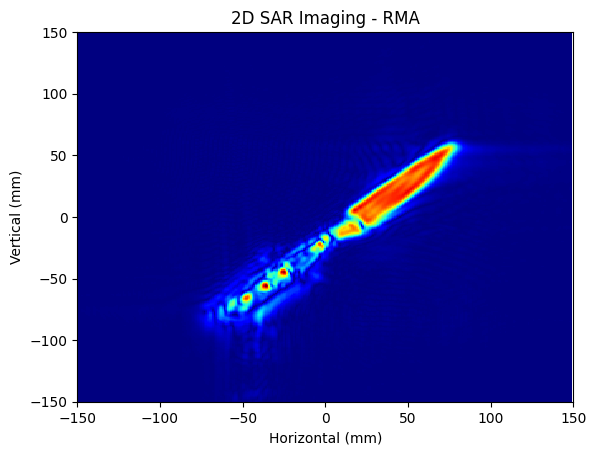

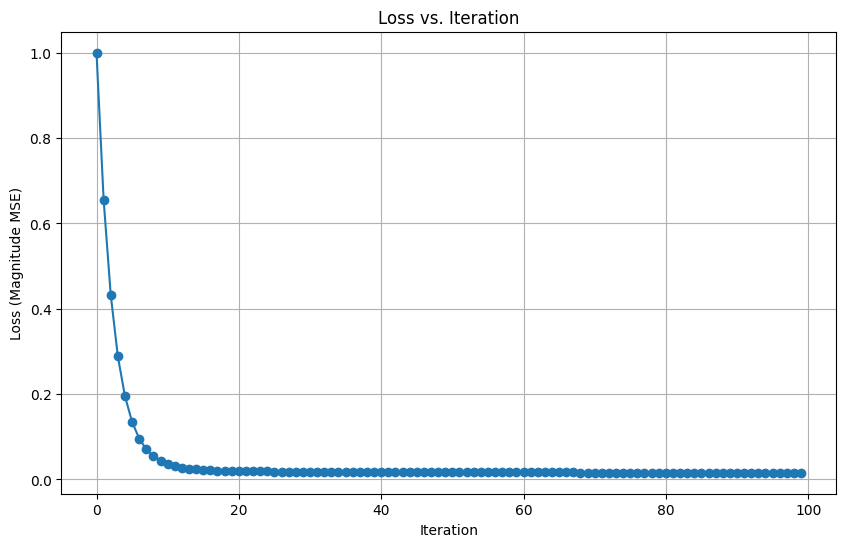

In [ ]:
# Calculate MSE between I_clean and I_target for reference
reference_mse = magnitude_mse_loss(torch.abs(I_clean), I_target)
print(f"Reference MSE between I_clean and I_target: {reference_mse.item()}")


# Now you can call the function whenever you want to restart the optimization
num_iterations=100
learning_rate=1e-2
epsilon=0.1
optimize_adversarial_attack(x_0, I_target, rma,num_iterations=num_iterations, learning_rate=learning_rate, epsilon=epsilon)

---------------------------------------------

In [ ]:
print(optimized_sar_data.dtype)

NameError: name 'optimized_sar_data' is not defined

## 2. SIMPLE ATTACK RMA


1.   Load 2D SAR data as sar_data_clean  
2.   Load target image pixels as sar_image_target generated using generate_target_image.ipynb






### Attack RMA


In [ ]:
'''
LOAD 2D sar data and sar target image pixels.
Generate clean dar image pixels using RMA
'''
# LOAD:
# RMA : RMA pytorch
# sar_data: clean range compressed 2D SAR data (complex)
# sar_image_target: taget image pixels (magnitude)

import sys
import scipy.io as sio
import torch

sys.path.append('/content/drive/MyDrive/Colab Notebooks/myMMwave/attack_v3/sar_imaging_pytorch_main') # main folder path

from sar_imaging_pytorch.imaging.rma import RMA

# -------- Define Parameters for the Matched Filter and Imaging
n_fft_space = 1024         # Number of FFT points for Spatial-FFT
dx = 1                      # Sampling distance at x (horizontal) axis in mm
dy = 1                      # Sampling distance at y (vertical) axis in mm
z_target = 185              # Target distance in mm (can adjust based on your setup)
im_size = [-150, 150, -150, 150]  # Image area size in mm (adjust as needed)
#---------------------------------------------------------

rma = RMA(nFFTspace=n_fft_space, z0=z_target*1e-3, dx=dx, dy=dy, bbox=im_size)

# 1) Load Clean Data

data_path_clean = '/content/drive/MyDrive/Colab Notebooks/myMMwave/attack_v3/sarData_rangeFocused_knife.mat'

data = sio.loadmat(data_path_clean)
#sar_data = torch.tensor(data['sarData']).to(torch.complex64) # load the clean data
sar_data_clean = torch.tensor(data['sarData'], dtype=torch.complex64, requires_grad=True)

# 2) Load the Target Image Pixel
target_image_path = '/content/drive/MyDrive/Colab Notebooks/myMMwave/attack_v3/sar_image_target_pixel.pt'
sar_image_target = torch.load(target_image_path)

#sar_image_target = (sar_image_target - sar_image_target.min()) / (sar_image_target.max() - sar_image_target.min())

<ipython-input-2-731287241cea>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sar_image_target = torch.load(target_image_path)


Size of sar_data (clean): torch.Size([200, 200]) Type: torch.complex64
Size of sar_image (clean): torch.Size([1024, 1024]) Type: torch.complex64
Size of sar_image_target (hallucinated): torch.Size([1024, 1024]) Type: torch.float32
SSIM between SAR image and target image: 2.0508670000548543e-18


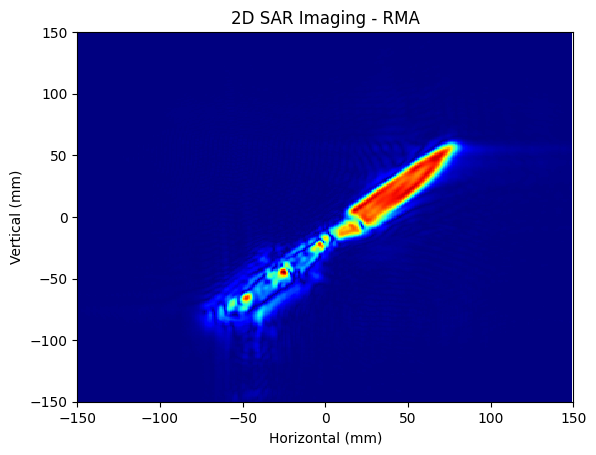

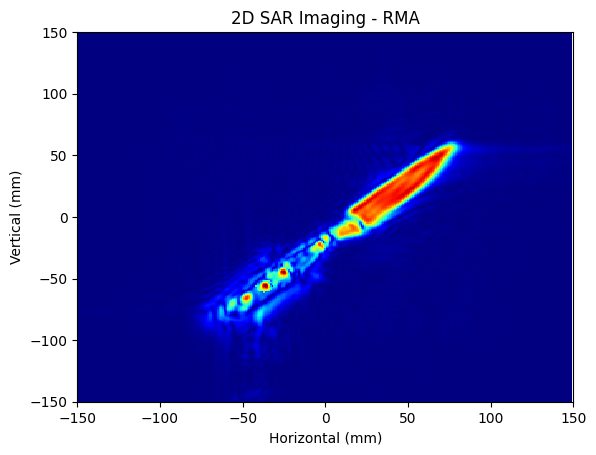

In [ ]:
'''
Check image size and type
SSIM : SAR image (clean) and Target image (Hallucinated)
PLOT : SAR image (clean) and Target image (Hallucinated)
'''

# CHECK
# Data type and size
# Plot
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np

print("Size of sar_data (clean):", sar_data_clean.size(), "Type:", sar_data_clean.dtype)

sar_image_clean = rma(sar_data_clean) # RMA algo

print("Size of sar_image (clean):", sar_image_clean.size(), "Type:", sar_image_clean.dtype)
print("Size of sar_image_target (hallucinated):", sar_image_target.size(), "Type:", sar_image_target.dtype)

# SSIM ------------------------------------------
# Convert the images to NumPy arrays and ensure they're in the correct format
sar_image_clean_np = torch.abs(sar_image_clean).detach().cpu().numpy()  # RMA output
sar_image_target_np = sar_image_target.detach().cpu().numpy()  # Target image

# If the images are complex, take the magnitude
if np.iscomplexobj(sar_image_clean_np):
    sar_image_np = np.abs(sar_image_clean_np)
if np.iscomplexobj(sar_image_target_np):
    sar_image_target_np = np.abs(sar_image_target_np)

# Normalize the images to [0, 1]
sar_image_np = (sar_image_clean_np - sar_image_clean_np.min()) / (sar_image_clean_np.max() - sar_image_clean_np.min())
sar_image_target_np = (sar_image_target_np - sar_image_target_np.min()) / (sar_image_target_np.max() - sar_image_target_np.min())

# Compute SSIM , add data_range
# data_range is the difference between the maximum and minimum values
# Since your data is normalized to [0, 1], data_range = 1
ssim_index, _ = ssim(sar_image_clean_np, sar_image_target_np, full=True, data_range=1.0) # Added data_range=1.0

# Print SSIM index
print(f'SSIM between SAR image and target image: {ssim_index}')
# SSIM ------------------------------------------

# PLOT
rma.plot_result(sar_image_clean)
rma.plot_result(sar_image_target)

Iteration 0, Loss: 21960968896512.0
Iteration 20, Loss: 2047680184320.0
Iteration 40, Loss: 459913003008.0
Iteration 60, Loss: 373983117312.0
Iteration 80, Loss: 361169289216.0


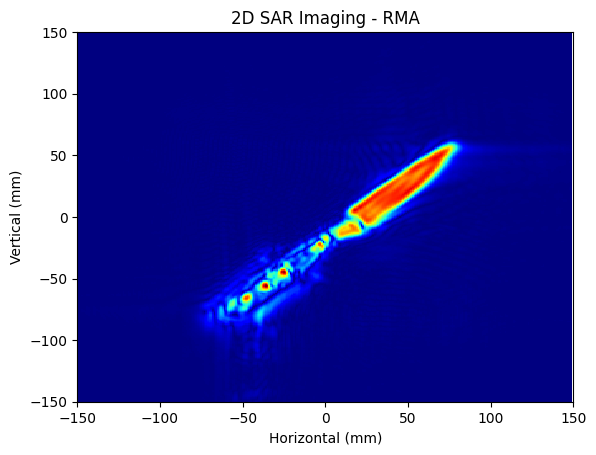

In [ ]:
'''
Gradient Optimization Algorithm
'''
# 3. Optimization

# Define the optimizer
#optimizer = torch.optim.Adam([sar_data_clean], lr=1e-1)  # Use a higher learning rate

# Define the optimizer using RMSProp
#optimizer = torch.optim.RMSprop([sar_data_clean], lr=1e-5)  # Adjust the learning rate as needed

# Define the optimizer using SGD with momentum
optimizer = torch.optim.SGD([sar_data_clean], lr=1e-3, momentum=0.9)  # Adjust the learning rate and momentum as needed

# Loss function: compare magnitude of complex output with real-valued target
def magnitude_mse_loss(output, target):
    return torch.mean((torch.abs(output) - target) ** 2)

# Define the number of iterations
num_iterations = 100  # Increase iterations if needed

for i in range(num_iterations):
    optimizer.zero_grad()

    # Forward pass: compute the RMA output
    rma_output = rma(sar_data_clean)

    # Compute the loss using the magnitude of the complex output and real target
    loss = magnitude_mse_loss(rma_output, sar_image_target)

    # Backward pass: compute gradients
    loss.backward()

    # Optionally clip gradients to prevent exploding gradients
    #torch.nn.utils.clip_grad_norm_([sar_data_clean], max_norm=1.0)

    # Update the parameters
    optimizer.step()

    if i % 20 == 0:
        print(f'Iteration {i}, Loss: {loss.item()}')

optimized_sar_data = sar_data_clean.detach()
rma.plot_result(torch.abs(rma(optimized_sar_data)))

In [ ]:
'''
Plot Optimized SAR Image
SSIM : Optimized SAR image (clean) and Target image (Hallucinated)
'''
# Final optimized SAR image
optimized_sar_data = sar_data_clean.detach()

optimized_sar_image = rma(optimized_sar_data)

# SSIM with the target sar sar_image_target
optimized_sar_image_np = optimized_sar_image.detach().cpu().numpy()
optimized_sar_image_np = np.abs(optimized_sar_image_np)
optimized_sar_image_np = (optimized_sar_image_np - optimized_sar_image_np.min()) / (optimized_sar_image_np.max() - optimized_sar_image_np.min())

# Compute SSIM, add data_range=1.0 since the image is normalized to [0, 1]
ssim_index, _ = ssim(optimized_sar_image_np, sar_image_target_np, full=True, data_range=1.0)

# Print SSIM index
print(f'SSIM between optimized SAR image and target image: {ssim_index}')

SSIM between optimized SAR image and target image: 0.9999752856317984


# ***RANDOM TEST***